# 1. Data loading & Dataset setting



  1-1. Load dataset

In [2]:
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Conv1D, MaxPooling1D, Dropout, Flatten, Activation
from sklearn.model_selection import KFold
print(tf.__version__)

import pandas as pd
import numpy as np
from numpy import *
from sklearn import svm
from scipy.stats import randint, uniform
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report,roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

# Load dataset
dataset = np.load('Filtered_Dataset.npz')['dataset']
dataset = pd.DataFrame(dataset)

# Load dataset (Label)
dataset_column_names = [str(i) for i in range(301)]
label_column_names = ['index', 'Data_Num', 'Vth', 'Mobility', 'S-Slope', 'On/Off']
uploaded_dataset_label_path = 'Ground Truth.csv'
label_dataset = pd.read_csv(uploaded_dataset_label_path, names = label_column_names, na_values="?", comment='\t', skipinitialspace=True)

# Delete unused columns from array
label_dataset.drop('Data_Num', axis=1, inplace=True)
label_dataset.drop('index', axis=1, inplace=True)


2.15.0


1-2. Setting input data

a. Mobility

In [3]:
# Make One-hot Vector label data
# Split 'Mobility' column from label_dataset(Vth, Mobility, SS, On/Off)
label_mobility = label_dataset['Mobility'].copy()
label_mobility = label_mobility.drop(0)
label_mobility = label_mobility.reset_index(drop=True)
label_mobility = label_mobility.astype(float)

# Make dataset used for model [ measured feature (idx:0~300) | mobility (idx:301)]
dataset = pd.concat([dataset, label_mobility], axis=1)

# train용 / test용 데이터 분할
train_dataset = dataset.sample(frac=0.8) # train_dataset을 같게 뽑으려면 dataset.sample(frac=0.8, random_state=0)로 수정하면 됩니다
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('Mobility')
test_labels = test_dataset.pop('Mobility')

b. Vth

In [4]:
# # Split 'Vth' column from label_dataset(Vth, Mobility, SS, On/Off)
# label_Vth = label_dataset['Vth'].copy()
# label_Vth = label_Vth.drop(0)
# label_Vth = label_Vth.reset_index(drop=True)
# label_Vth = label_Vth.astype(float)


# # Make dataset used for model [ measured feature (idx:0~300) | Vth (idx:301)]
# dataset = pd.concat([dataset, label_Vth], axis=1)
# train_dataset = dataset.sample(frac=0.8,random_state=0)
# test_dataset = dataset.drop(train_dataset.index)

# train_labels = train_dataset.pop('Vth')
# test_labels = test_dataset.pop('Vth')

c. SS

In [ ]:
# # Split 'SS' column from label_dataset(Vth, Mobility, SS, On/Off)
# label_SS = label_dataset['S-Slope'].copy()
# label_SS = label_SS.drop(0)
# label_SS = label_SS.reset_index(drop=True)
# label_SS = label_SS.astype(float)


# # Make dataset used for model [ measured feature (idx:0~300) | SS (idx:301)]
# dataset = pd.concat([dataset, label_SS], axis=1)
# train_dataset = dataset.sample(frac=0.8,random_state=0)
# test_dataset = dataset.drop(train_dataset.index)

# train_labels = train_dataset.pop('S-Slope')
# test_labels = test_dataset.pop('S-Slope')


d. On/Off

In [ ]:
# # Split 'On/Off' column from label_dataset(Vth, Mobility, SS, On/Off)
# label_OnOff = label_dataset['On/Off'].copy()
# label_OnOff = label_OnOff.drop(0)
# label_OnOff = label_OnOff.reset_index(drop=True)
# label_OnOff = label_OnOff.astype(float)


# # Make dataset used for model [ measured feature (idx:0~300) | SS (idx:301)]
# dataset = pd.concat([dataset, label_OnOff], axis=1)
# train_dataset = dataset.sample(frac=0.8,random_state=0)
# test_dataset = dataset.drop(train_dataset.index)

# train_labels = train_dataset.pop('On/Off')
# test_labels = test_dataset.pop('On/Off')


1-3. Visualize input data

In [6]:
# VIsualize train_dataset
# sns.pairplot(train_dataset[[0, 5, 10, 15]], diag_kind="kde")

# Statistic feature of train_dataset
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
0,319.0,6.838088e-10,1.194986e-08,8.200000e-12,1.210000e-11,1.370000e-11,1.535000e-11,2.134460e-07
1,319.0,5.185047e-11,6.982059e-10,2.700000e-12,1.030000e-11,1.190000e-11,1.350000e-11,1.248260e-08
2,319.0,1.415549e-11,4.433526e-11,2.700000e-12,9.200000e-12,1.090000e-11,1.255000e-11,7.967000e-10
3,319.0,1.098464e-11,5.707111e-12,2.700000e-12,8.600000e-12,1.020000e-11,1.170000e-11,7.440000e-11
4,319.0,1.041567e-11,5.268723e-12,2.700000e-12,8.100000e-12,9.700000e-12,1.125000e-11,6.630000e-11
...,...,...,...,...,...,...,...,...
296,319.0,3.526184e-03,3.998846e-04,2.275510e-03,3.221270e-03,3.545550e-03,3.842105e-03,4.456900e-03
297,319.0,3.561948e-03,4.037194e-04,2.297350e-03,3.253490e-03,3.580480e-03,3.881510e-03,4.499320e-03
298,319.0,3.597695e-03,4.077501e-04,2.319210e-03,3.287095e-03,3.617200e-03,3.920855e-03,4.542130e-03
299,319.0,3.633615e-03,4.115583e-04,2.341170e-03,3.320875e-03,3.654680e-03,3.960565e-03,4.584440e-03


1-4. Split train data, train data's label, test data, test data's label

In [7]:
# Detach the column from train_dataset & test_dataset

# Data Normalization
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)



---



# 2. Construct CNN structure

In [8]:
def cnn_model():
  model = Sequential([
      Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(301, 1)),
      MaxPooling1D(pool_size=2),
      Conv1D(filters=64, kernel_size=3, activation='relu'),
      MaxPooling1D(pool_size=2),
      Flatten(),
      Dense(128, activation='relu'),
      Dense(1)
  ])
  return model

model = cnn_model()

model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 299, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 149, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 147, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 73, 64)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 4672)              0         
                                                                 
 dense (Dense)               (None, 128)               5



---



# 3. train

In [9]:
# 100 Epochs
EPOCHS = 100

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0)

 3-1. Visualize model training process

In [10]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,0.825911,0.555657,0.825911,2.566249,1.052052,2.566249,95
96,0.757416,0.522064,0.757416,2.455410,0.983810,2.455410,96
97,0.761705,0.552556,0.761705,2.426592,0.764364,2.426592,97
98,0.734485,0.481904,0.734485,2.559948,0.734630,2.559948,98
99,0.746585,0.492500,0.746585,2.438204,0.806125,2.438204,99


3-2. Training without EarlyStopping callback

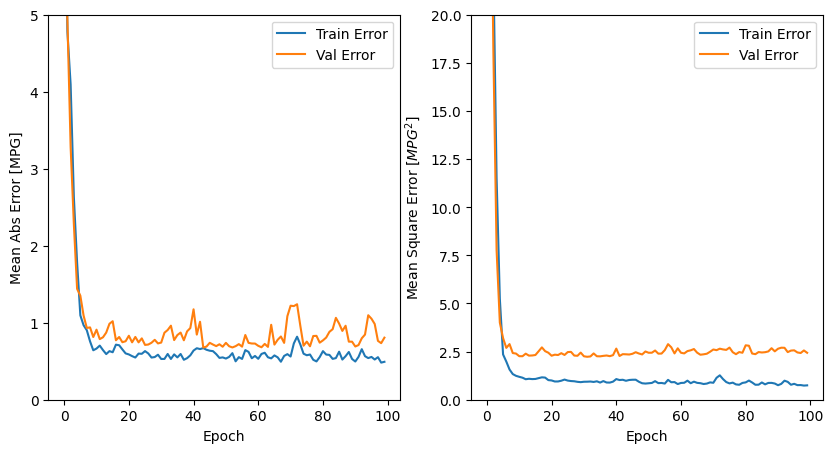

In [14]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(10,5))

  plt.subplot(1,2,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)



---




# 5. Test

In [15]:
# For model evaluation, change Pandas(DataFrame) to Numpy with float type
normed_test_data_array = normed_test_data.to_numpy().astype(float)
loss, mae, mse = model.evaluate(normed_test_data_array, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 1.0883 - mae: 0.5563 - mse: 1.0883 - 199ms/epoch - 66ms/step
테스트 세트의 평균 절대 오차:  0.56 MPG


5-1. Visualize Prediction (with test data)

3/3 [==============================] - 0s 9ms/step
(80, 1)


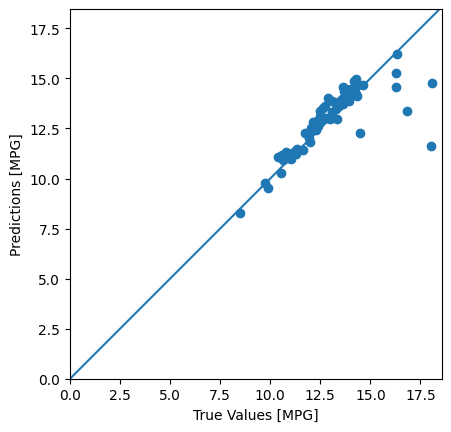

In [16]:
test_predictions = model.predict(normed_test_data)
plt.scatter(test_labels, test_predictions)

print(test_predictions.shape)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

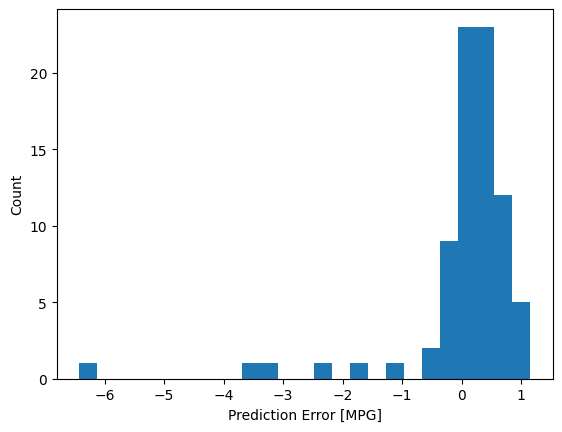

In [17]:
test_predictions = np.array(test_predictions).flatten()
test_labels = test_labels.values.flatten()

error = test_predictions - test_labels

plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")